In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/floris/development/gitrepos/retinanet/own/keras-retinanet")


import keras
import keras_retinanet

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

from keras_retinanet.preprocessing import PascalVocIterator

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

def prepare_image(cv_image, image_min_side=600, image_max_side=1024):

    image = cv_image
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    S_time = time.time()
    image /= 255.0
    print("Time spend in normalisation: {}".format(time.time() - S_time))
    image_batch = np.expand_dims(image, axis=0)

    return image_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate RetinaNet model

In [29]:
image = keras.layers.Input((None, None, 3))
model = keras_retinanet.models.ResNet50RetinaNet(image, num_classes=90, weights='resnet50_coco_best.h5')

# compile model
model.compile(
    loss={
        'regression'    : keras_retinanet.losses.regression_loss,
        'classification': keras_retinanet.losses.focal_loss()
    },
    optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)
)
#print(model.summary())

/home/floris/development/gitrepos/retinanet/retinanet/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  # Remove the CWD from sys.path while we load stuff.


## Initialize data generators

In [30]:
# create image data generator objects
train_image_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
)
test_image_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0,
)

# create a generator for training data
train_generator = keras_retinanet.preprocessing.coco.CocoIterator(
    '/home/floris/dataset/COCO/',
    'train2017',
    train_image_data_generator,
)

# create a generator for testing data
test_generator = PascalVocIterator(
        '/home/floris/dataset/VOC/VOCdevkit/VOC2012',
        'test',
        test_image_data_generator
    )

loading annotations into memory...
Done (t=15.37s)
creating index...
index created!


## Train on data

In [48]:
batch_size = 1 # batch_size > 1 is not yet supported
model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator.image_ids) // batch_size,
    epochs=50,
    verbose=1,
    validation_data=test_generator,
    validation_steps=500,#len(test_generator.image_ids) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint('snapshots/resnet50_coco_best.h5', monitor='val_loss', verbose=1, save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0),
    ],
)

Epoch 1/50


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/floris/development/gitrepos/retinanet/retinanet/lib/python3.5/site-packages/keras/utils/data_utils.py", line 568, in data_generator_task
    generator_output = next(self._generator)
  File "/home/floris/development/gitrepos/retinanet/retinanet/lib/python3.5/site-packages/keras/preprocessing/image.py", line 737, in __next__
    return self.next(*args, **kwargs)
  File "/home/floris/development/gitrepos/retinanet/own/keras-retinanet/keras_retinanet/preprocessing/coco.py", line 145, in next
    image_data = self.load_image(selection[0])
  File "/home/floris/development/gitrepos/retinanet/own/keras-retinanet/keras_retinanet/preprocessing/coco.py", line 81, in load_image
    image, image_scale = resize_image(image, min_side=

StopIteration: 

## Run detection on example

processing time:  0.3024282455444336


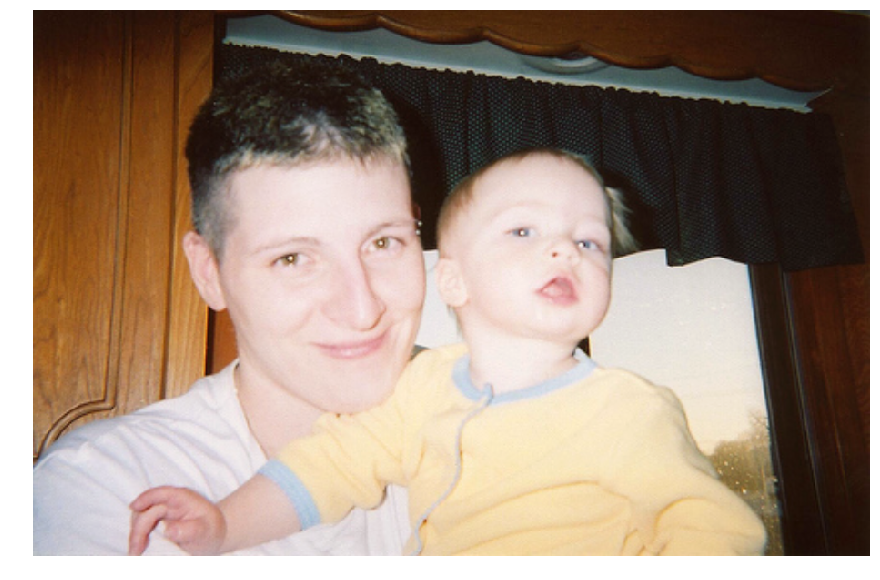

In [47]:
batch_size = 1
image_batch, outputs = next(test_generator)
image = image_batch[0, ...].copy()


image -= min(image.flatten())
image /= max(image.flatten())
image *= 255
image = image.astype(np.uint8)

start = time.time()
_, _, detections = model.predict_on_batch(image_batch)
print("processing time: ", time.time() - start)

im = image.copy()
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = np.max(detections[0, :, 4:], axis=1)

for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    #if label == 0:
    #    continue
    if score < 0.5:
        continue
        
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(im, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 3)
    caption = "{} {:.3f}".format("test", score)
    cv2.putText(im, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(im, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(im)
plt.show()